In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit

In [2]:
# another try for a Gillespie algorithm...

def gillespie_plot(a0,l0,m0,n_reactions,n_sims,step_change,cnew,n_avesteps,
                   E0=3,delta_f=-2,taul=0.001,Ki=18,Ka=2900,N=6,kR=0.1,kB=0.2,mMax=24,kAct=10**3,
                       methylation=True,ligand=True,activation=True):
    # set up arrays to hold the results
    recorded_time = np.zeros((n_sims, n_reactions+1))
    all_states = np.zeros((n_sims, n_reactions+1, 3))
    
    # set initial conditions
    all_states[:,0,0] = a0
    all_states[:,0,1] = l0
    all_states[:,0,2] = m0
    
    ############# actual algorithm #############
    for i in range(n_sims):
        for j in range(n_reactions):
            # set the events with the corresponding rates
            rates = np.zeros(4)
            events = np.zeros((4,3))

            # change concentration after tchange
            if j > step_change:
                c = cnew
            else:
                c = 100
            
            # calculate ligand binding rate
            kplus = 1/(taul*(c + Ki))

            # calculate free-energy difference
            f = E0 + all_states[i,j,1]*np.log(Ka/Ki) + delta_f*all_states[i,j,2]

            # set rate constants for (de)activation
            kDeact = kAct*np.exp(f)

            # check methylation states
            meth_ceiling = all_states[i,j,2] < mMax
            meth_floor = all_states[i,j,2] > 0
            
            # for inactive cluster
            if all_states[i,j,0] == 0:
                # ligand binding
                rates[0] = kplus*c*(N - all_states[i,j,1])*ligand
                events[0] = [0,1,0]

                # ligand unbinding
                rates[1] = kplus*Ki*all_states[i,j,1]*ligand
                events[1] = [0,-1,0]

                # methylation; only possible if a site is available
                rates[2] = kR*meth_ceiling*methylation
                events[2] = [0,0,1]

                # activity switching
                rates[3] = kAct*activation
                events[3] = [1,0,0]

            # for active cluster
            else:
                # ligand binding
                rates[0] = kplus*c*(N - all_states[i,j,1])*ligand
                events[0] = [0,1,0]

                # ligand unbinding
                rates[1] = kplus*Ka*all_states[i,j,1]*ligand
                events[1] = [0,-1,0]

                # demethylation; only possible if a site is occupied
                rates[2] = kB*meth_floor*methylation
                events[2] = [0,0,-1]

                # deactivation
                rates[3] = kDeact*activation
                events[3] = [-1,0,0]

            # determine which event occurs
            p = np.random.uniform(0,1)*np.sum(rates)
            mask = p < np.cumsum(rates)
            event_idx = np.where(mask == True)[0][0]

            # this samples the time until the next event
            u = np.random.uniform(0,1)
            dt = -np.log(u)/np.sum(rates)
            
            # store reaction time
            recorded_time[i,j+1] = recorded_time[i,j] + dt
            
            # update the state
            all_states[i,j+1,:] = all_states[i,j,:] + events[event_idx]
    
    # normalise ligand binding and methylation level
    all_states[:,:,1] = all_states[:,:,1]/N
    all_states[:,:,2] = all_states[:,:,2]/mMax
    
    ############## averaging ##############
    
    # extract maximal time
    t_max = recorded_time.max()
    
    # set up arrays with averaged results
    ave_time = np.linspace(0,t_max,n_avesteps+1)
    ave_states = np.zeros((n_avesteps+1, 3))
    
    # set initial states
    ave_states[0,0] = a0
    ave_states[0,1] = l0/N
    ave_states[0,2] = m0/mMax
        
    for i in range(1,n_avesteps+1):
        # construct interval over which to average
        t_boundary = ave_time[i]
        tot = np.zeros(3,dtype='float64')
        # a counter for how many events happened in this interval
        counter = 0
        
        for j in range(n_sims):
            for k in range(n_reactions):
                # check that the recorded time is inside the interval
                # the next time step should be in the next averaged bin
                if recorded_time[j,k] <= t_boundary and recorded_time[j,k+1] > t_boundary:
                    counter += 1
                    tot += all_states[j,k,:]
        
        # take average over interval
        # if nothing happened, then set to previous state
        if counter == 0:
            ave_states[i,:] = ave_states[i-1,:]
        else:
            ave_states[i,:] = tot/counter
    
    # plot the results for inspection
    fig, axes = plt.subplots(3,1, figsize=(6,12))
    
    # labels for plotting
    names = ['Activity', 'Fractional receptor occupancy', 'Normalised methylation level']
    
    for i, ax in enumerate(axes):
        # show trajectories
        for j in range(n_sims):
            ax.plot(recorded_time[j,:], all_states[j,:,i], marker='', color='grey', linewidth=0.6, alpha=0.2)
        # show the averaged results
        ax.plot(ave_time, ave_states[:,i],color='red')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel(names[i])
           
    plt.show()
            
    return ave_states, ave_time

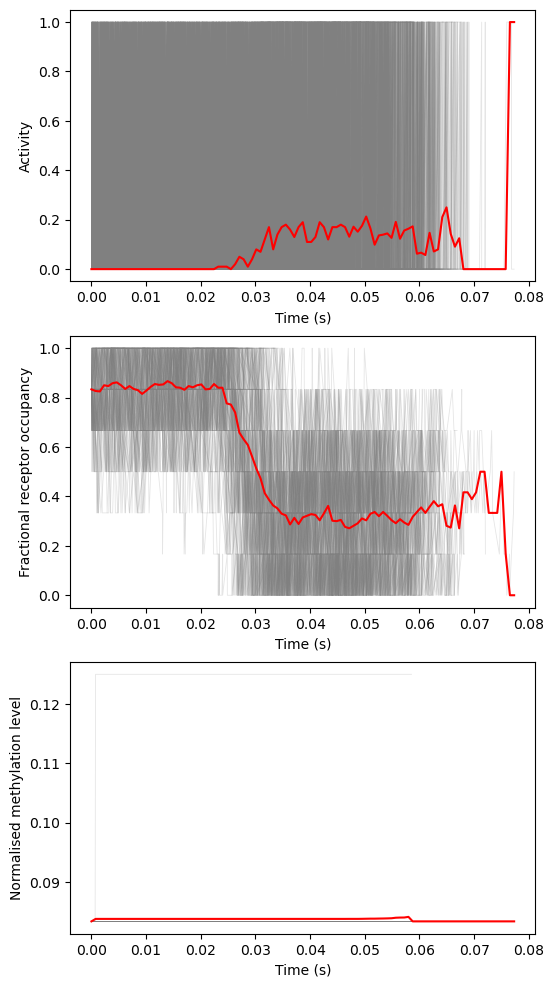

In [4]:
a0 = 0.
l0 = 5.
m0 = 2.
n_reactions = 250
n_sims = 100
step_change = 100
cnew = 10
n_avesteps = 100

ave_states, ave_time = gillespie_plot(a0,l0,m0,n_reactions,n_sims,step_change,cnew,n_avesteps)

In [131]:
@numba.jit(nopython=True)

def gillespie_numba(a0,l0,m0,n_reactions,n_sims,step_change,cnew,n_avesteps,
                   E0=3,delta_f=-2,taul=0.001,Ki=18,Ka=2900,N=6,kR=0.1,kB=0.2,mMax=24,kAct=10**3,
                       methylation=True,ligand=True,activation=True):
    # set up arrays to hold the results
    recorded_time = np.zeros((n_sims, n_reactions+1))
    all_states = np.zeros((n_sims, n_reactions+1, 3))
    
    # set initial conditions
    all_states[:,0,0] = a0
    all_states[:,0,1] = l0
    all_states[:,0,2] = m0
    
    ############# actual algorithm #############
    for i in range(n_sims):
        for j in range(n_reactions):
            # set the events with the corresponding rates
            rates = np.zeros(4)
            events = np.zeros((4,3))

            # set concentration
            if j > step_change:
                c = cnew
            else: 
                c = 100
            
            # calculate ligand binding rate
            kplus = 1/(taul*(c + Ki))

            # calculate free-energy difference
            f = E0 + all_states[i,j,1]*np.log(Ka/Ki) + delta_f*all_states[i,j,2]

            # set rate constants for (de)activation
            kDeact = kAct*np.exp(f)

            # check methylation states
            meth_ceiling = all_states[i,j,2] < mMax
            meth_floor = all_states[i,j,2] > 0
            
            # for inactive cluster
            if all_states[i,j,0] == 0:
                # ligand binding
                rates[0] = kplus*c*(N - all_states[i,j,1])*ligand
                events[0] = [0,1,0]

                # ligand unbinding
                rates[1] = kplus*Ki*all_states[i,j,1]*ligand
                events[1] = [0,-1,0]

                # methylation; only possible if a site is available
                rates[2] = kR*meth_ceiling*methylation
                events[2] = [0,0,1]

                # activity switching
                rates[3] = kAct*activation
                events[3] = [1,0,0]

            # for active cluster
            else:
                # ligand binding
                rates[0] = kplus*c*(N - all_states[i,j,1])*ligand
                events[0] = [0,1,0]

                # ligand unbinding
                rates[1] = kplus*Ka*all_states[i,j,1]*ligand
                events[1] = [0,-1,0]

                # demethylation; only possible if a site is occupied
                rates[2] = kB*meth_floor*methylation
                events[2] = [0,0,-1]

                # deactivation
                rates[3] = kDeact*activation
                events[3] = [-1,0,0]

            # determine which event occurs
            p = np.random.uniform(0,1)*np.sum(rates)
            mask = p < np.cumsum(rates)
            event_idx = np.where(mask == True)[0][0]

            # this samples the time until the next event
            u = np.random.uniform(0,1)
            dt = -np.log(u)/np.sum(rates)
            
            # store reaction time
            recorded_time[i,j+1] = recorded_time[i,j] + dt
            
            # update the state
            all_states[i,j+1,:] = all_states[i,j,:] + events[event_idx]
    
    # normalise ligand binding and methylation level
    all_states[:,:,1] = all_states[:,:,1]/N
    all_states[:,:,2] = all_states[:,:,2]/mMax
    
    ############## averaging ##############
    
    # extract maximal time
    t_max = recorded_time.max()
    
    # set up arrays with averaged results
    ave_time = np.linspace(0,t_max,n_avesteps+1)
    ave_states = np.zeros((n_avesteps+1, 3))
    
    # set initial states
    ave_states[0,0] = a0
    ave_states[0,1] = l0/N
    ave_states[0,2] = m0/mMax
        
    for i in range(1,n_avesteps+1):
        # construct interval over which to average
        t_boundary = ave_time[i]
        tot = np.zeros(3,dtype='float64')
        # a counter for how many events happened in this interval
        counter = 0
        
        for j in range(n_sims):
            for k in range(n_reactions):
                # check that the recorded time is inside the interval
                # the next time step should be in the next averaged bin
                if recorded_time[j,k] <= t_boundary and recorded_time[j,k+1] > t_boundary:
                    counter += 1
                    tot += all_states[j,k,:]
        
        # take average over interval
        # if nothing happened, then set to previous state
        if counter == 0:
            ave_states[i,:] = ave_states[i-1,:]
        else:
            ave_states[i,:] = tot/counter
            
    return ave_states, ave_time

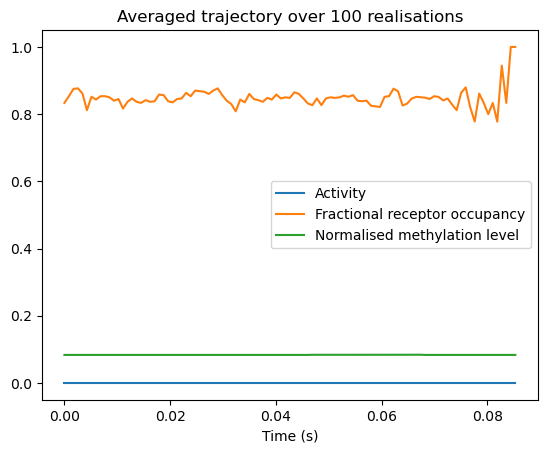

In [134]:
a0 = 0.
l0 = 5.
m0 = 2.
n_reactions = 250
n_sims = 100
step_change = 20
cnew = 100
n_avesteps = 100

# obtain results
ave_states, ave_time = gillespie_numba(a0,l0,m0,n_reactions,n_sims,step_change,cnew,n_avesteps)

# plotting
names = ['Activity', 'Fractional receptor occupancy', 'Normalised methylation level']

for i in range(3):
    plt.plot(ave_time, ave_states[:,i],label=names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.title(f'Averaged trajectory over {n_sims} realisations')

plt.show()